This page runs two experiments to find best resampling methods to be used in DWI processing pipelines:

#1) Mask resampling to DWI space

After DWI image is corrected and aligned to T2 image space, we need to resample the FreeSurfer_extended label map as a binary labelmap to DWI voxel space, since it is needed by further processings of compressed sesning and tractography. 

In this experiment we investigate the best binary resampling method to resample the FreeSurfer_extended label map from its original isotropic (1x1x1 mm^3) space to the voxel space of corrected aligned DWI image.

* Validation Method:

First, we find the volume covered by FreeSurfer_extended label map in its original isotropic space. This value will be our baseline measure.

Then, we compute the covered volume again after the label map was resampled to DWI voxel space.
Note that we choose a DWI test case that has no cropping and its field of view (FOV) completely covers the resampled label map.

We choose a resampling method that creates close measured volumes before and after resampling.


#2) RIS resampling to isotropic space (1x1x1 mm^3) of T2LabelMap

In measurement workflow, we need to resample the computed rotationally invariant scalar images to the istropic voxel space of FreeSurfer_extended label map to compute each RIS statistics in different regions of brain. This experiment investigates the best resampling method for this purpose.

* Validation Method:

First we compute the statistics of FA in its original space using the label map created from experiment 1.

Then, we compute the whole brain statistics of FA again after it is resampled to istropic voxel space of FreeSurfer_extended label map. 

We choose a resampling method that creates close statistics to our baseline measures.

In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.0.dev2151-g2a716
Compiled: Dec 23 2014 21:10:53



In [2]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
import nipype.interfaces.matlab as matlab
from SEMTools import *

In [3]:
TestDIR='/scratch/TESTS/IpythonNotebook/5_TestForDifferentWaysOfMaskResampling'

# Inputs:

In choosing the sample test cases, we need to notice that processed (corrected and aligned) DWI test case should have no cropping and its field of view (FOV) should completely cover the resampled label map.

16-bit unsigned integer


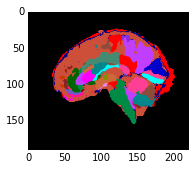

In [4]:
labels_filename = '/Shared/sinapse/CACHE/20141001_PREDICTHD_long_Results/PHD_120/0095/13195/TissueClassify/fswm_extended_neuro2012_20_merge_seg.nii.gz'
neuroLabels = sitk.ReadImage(labels_filename)
size=neuroLabels.GetSize()
myshow(sitk.LabelToRGB(neuroLabels[size[0]//2,:,::-1]))
print(neuroLabels.GetPixelIDTypeAsString())

16-bit signed integer


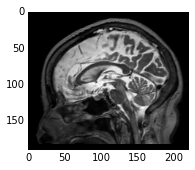

In [89]:
T2_filename = '/Shared/sinapse/CACHE/20141001_PREDICTHD_long_Results/PHD_120/0095/13195/TissueClassify/t2_average_BRAINSABC.nii.gz'
T2 = sitk.ReadImage(T2_filename)
size=T2.GetSize()
myshow(T2[size[0]//2,:,::-1])
print(T2.GetPixelIDTypeAsString())

# Baseline value for experiment 1:

We compute volume covered by FreeSurfer_extended label map in its original isotropic space. This measure will be our ground truth for the first experiment.

In [90]:
whole_mask = neuroLabels>0
labelID=1

statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(T2, whole_mask)
print(statFilter.GetNumberOfLabels())
print('Num of voxels:',statFilter.GetCount(labelID))
voxelSize=T2.GetSpacing()[0]*T2.GetSpacing()[1]*T2.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

2
Num of voxels: 1188493
effective_volume: 1188493.0


#### Therefore, our Baseline measure is: 1,188,493 (mm^3)

16-bit signed integer


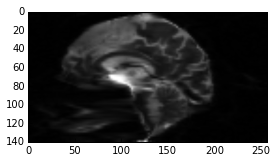

In [91]:
DWI_aligned_B0_fn = '/Shared/johnsonhj/HDNI/20150319_DWIProcessing/Results/PHD_120/0095/13195/DWIWorkflow_CACHE_13195/CorrectionWorkflow_CACHE_13195/gtractResampleDWIInPlace_TuneRigidTx/CorrectedDWI_in_T2Space_B0.nrrd'
DWI_aligned_B0 = sitk.ReadImage(DWI_aligned_B0_fn)
size=DWI_aligned_B0.GetSize()
myshow(sitk.Expand(DWI_aligned_B0[size[0]//2,:,:],[4,4,4]))
print(DWI_aligned_B0.GetPixelIDTypeAsString())

###### Now we use the following methods to resample the FreeSurfer_extended label map to the voxel space of corrected aligned DWI image:

1) Use BRAINSResample with interpolationMode = 'Linear' and output pixelType = 'binary'

2) Use SimpleITK resampleImageFitler wiht NearestNeighbor interpolation

3) Use SimpleITK resampleImageFitler wiht LabelGaussian interpolation

4) Use SimpleITK resampleImageFitler wiht Linear interpolation + Thresholding at 0

5) Use SimpleITK resampleImageFitler wiht Linear interpolation + Thresholding at 0<t<1



In [92]:
# 1- by BRIANSResample
bResample = BRAINSResample()
bResample.inputs.inputVolume = labels_filename
bResample.inputs.interpolationMode = 'Linear'
bResample.inputs.pixelType = 'binary'
bResample.inputs.referenceVolume = DWI_aligned_B0_fn
bResample.inputs.outputVolume = os.path.join(TestDIR, 'maskByBResample.nrrd')
bResample.run()

whole_mask = sitk.ReadImage(bResample.inputs.outputVolume)
labelID=1
statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(DWI_aligned_B0, whole_mask)
print(statFilter.GetNumberOfLabels())
print('Num of voxels:',statFilter.GetCount(labelID))
voxelSize=DWI_aligned_B0.GetSpacing()[0]*DWI_aligned_B0.GetSpacing()[1]*DWI_aligned_B0.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

INFO:interface:stdout 2015-05-01T18:54:17.055647:WARNING: neither warpTransform nor deformationVolume are defined, so warpTransform is set as identity.
INFO:interface:stdout 2015-05-01T18:54:17.055647:=====================================================
INFO:interface:stdout 2015-05-01T18:54:17.055647:Input Volume:     /Shared/sinapse/CACHE/20141001_PREDICTHD_long_Results/PHD_120/0095/13195/TissueClassify/fswm_extended_neuro2012_20_merge_seg.nii.gz
INFO:interface:stdout 2015-05-01T18:54:17.055647:Reference Volume: /Shared/johnsonhj/HDNI/20150319_DWIProcessing/Results/PHD_120/0095/13195/DWIWorkflow_CACHE_13195/CorrectionWorkflow_CACHE_13195/gtractResampleDWIInPlace_TuneRigidTx/CorrectedDWI_in_T2Space_B0.nrrd
INFO:interface:stdout 2015-05-01T18:54:17.055647:Output Volume:    /scratch/TESTS/IpythonNotebook/5_TestForDifferentWaysOfMaskResampling/maskByBResample.nrrd
INFO:interface:stdout 2015-05-01T18:54:17.055647:Pixel Type:       binary
INFO:interface:stdout 2015-05-01T18:54:17.055647:I

2
Num of voxels: 152504
effective_volume: 1220032.0


In [93]:
# 2- sitk + NearestNeighbor 

# binary_mask
binary_mask = neuroLabels>0
# resample to DWI space
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(DWI_aligned_B0)
resFilt.SetInterpolator(sitk.sitkNearestNeighbor)
resampled_mask = resFilt.Execute(binary_mask)

whole_mask = resampled_mask
labelID=1
statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(DWI_aligned_B0, whole_mask)
print(statFilter.GetNumberOfLabels())
print('Num of voxels:',statFilter.GetCount(labelID))
voxelSize=DWI_aligned_B0.GetSpacing()[0]*DWI_aligned_B0.GetSpacing()[1]*DWI_aligned_B0.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

2
Num of voxels: 148544
effective_volume: 1188352.0


In [94]:
# 3- sitk + LabelGaussian  

# binary_mask
binary_mask = neuroLabels>0
# resample to DWI space
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(DWI_aligned_B0)
resFilt.SetInterpolator(sitk.sitkLabelGaussian)
resampled_mask = resFilt.Execute(binary_mask)

whole_mask = resampled_mask
labelID=1
statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(DWI_aligned_B0, whole_mask)
print(statFilter.GetNumberOfLabels())
print('Num of voxels:',statFilter.GetCount(labelID))
voxelSize=DWI_aligned_B0.GetSpacing()[0]*DWI_aligned_B0.GetSpacing()[1]*DWI_aligned_B0.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

2
Num of voxels: 148489
effective_volume: 1187912.0


In [95]:
# 4- sitk + linear + threshold 0

# binary_mask
binary_mask = neuroLabels>0
# resample to DWI space
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(DWI_aligned_B0)
resFilt.SetOutputPixelType(sitk.sitkFloat32)
resFilt.SetInterpolator(sitk.sitkLinear)
resampled_mask = resFilt.Execute(binary_mask)
# Thresholding by 0
threshFilt = sitk.BinaryThresholdImageFilter()
thresh_resampled_mask = threshFilt.Execute(resampled_mask,0.0001,1.0,1,0)
sitk.WriteImage(thresh_resampled_mask,os.path.join(TestDIR, 'maskBySITK_Linear_0_thresh.nrrd'))

whole_mask = thresh_resampled_mask
labelID=1
statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(DWI_aligned_B0, whole_mask)
print(statFilter.GetNumberOfLabels())
print('Num of voxels:',statFilter.GetCount(labelID))
voxelSize=DWI_aligned_B0.GetSpacing()[0]*DWI_aligned_B0.GetSpacing()[1]*DWI_aligned_B0.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

2
Num of voxels: 154523
effective_volume: 1236184.0


In [96]:
# 5- sitk + linear + threshold 0.49

# binary_mask
binary_mask = neuroLabels>0
# resample to DWI space
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(DWI_aligned_B0)
resFilt.SetOutputPixelType(sitk.sitkFloat32)
resFilt.SetInterpolator(sitk.sitkLinear)
resampled_mask = resFilt.Execute(binary_mask)
# Thresholding by 0.5
threshFilt = sitk.BinaryThresholdImageFilter()
thresh_resampled_mask = threshFilt.Execute(resampled_mask,0.49,1.0,1,0)
sitk.WriteImage(thresh_resampled_mask,os.path.join(TestDIR, 'maskBySITK_linear_0.5_thresh.nrrd'))

whole_mask = thresh_resampled_mask
labelID=1
statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(DWI_aligned_B0, whole_mask)
print(statFilter.GetNumberOfLabels())
print('Num of voxels:',statFilter.GetCount(labelID))
voxelSize=DWI_aligned_B0.GetSpacing()[0]*DWI_aligned_B0.GetSpacing()[1]*DWI_aligned_B0.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

2
Num of voxels: 148599
effective_volume: 1188792.0


##### Therefore, based on the above results, the optimal resampling method for Mask resampling is:

### SimpleITK resampleImageFitler with 'Linear' interpolation + Thresholding at 0.49

# ----------------------------------------------------------------------------

# Experiment 2) RIS resampling to isotropic space (1x1x1 mm^3) of FreeSurfer extended label map

64-bit float


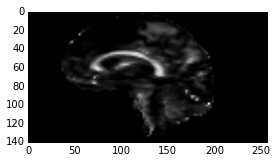

In [97]:
FA_fn = '/Shared/johnsonhj/HDNI/20150319_DWIProcessing/Results/PHD_120/0095/13195/Outputs/DTI_RIS/FA.nrrd'
FA = sitk.ReadImage(FA_fn)
size=FA.GetSize()
myshow(sitk.Expand(FA[size[0]//2,:,:],[4,4,4]))
print(FA.GetPixelIDTypeAsString())

###### First we compute the statistics of FA in its original space using the label map created from experiment 1.

In [98]:
print(whole_mask.GetPixelIDTypeAsString())

statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(FA, whole_mask)
print(statFilter.GetNumberOfLabels())
labelID=1

print('mean:',statFilter.GetMean(labelID))
print('std:',statFilter.GetSigma(labelID))
print('max:',statFilter.GetMaximum(labelID))
print('min:',statFilter.GetMinimum(labelID))
print('median:',statFilter.GetMedian(labelID))
print('Num of voxels:',statFilter.GetCount(labelID))

voxelSize=FA.GetSpacing()[0]*FA.GetSpacing()[1]*FA.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

8-bit unsigned integer
2
mean: 0.137543948377
std: 0.147001117319
max: 1.22474291654
min: 0.0
median: 0.0885068103671
Num of voxels: 148599
effective_volume: 1188792.0


###### Now we test the following resampling methods:

### 1) SimpleIKT + 'Linear' interpolation

2
mean: 0.137381385455
std: 0.134830367396
max: 1.1836113099
min: 0.0
median: 0.0947813726962
Num of voxels: 1188493
effective_volume: 1188493.0


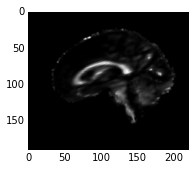

In [99]:
# resample FA to label map space
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(neuroLabels)
resFilt.SetOutputPixelType(FA.GetPixelIDValue())
resFilt.SetInterpolator(sitk.sitkLinear)
FA_res = resFilt.Execute(FA)

size=FA_res.GetSize()
myshow(FA_res[size[0]//2,:,::-1])
####################### 

whole_brain_mask = neuroLabels>0
labelID = 1

statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(FA_res, whole_brain_mask)
print(statFilter.GetNumberOfLabels())
print('mean:',statFilter.GetMean(labelID))
print('std:',statFilter.GetSigma(labelID))
print('max:',statFilter.GetMaximum(labelID))
print('min:',statFilter.GetMinimum(labelID))
print('median:',statFilter.GetMedian(labelID))
print('Num of voxels:',statFilter.GetCount(labelID))
voxelSize=FA_res.GetSpacing()[0]*FA_res.GetSpacing()[1]*FA_res.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

### 2) SimpleIKT + 'Gaussian' interpolation

In [100]:
# resample FA to label map space
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(neuroLabels)
resFilt.SetOutputPixelType(FA.GetPixelIDValue())
resFilt.SetInterpolator(sitk.sitkGaussian )
FA_res = resFilt.Execute(FA)

####################### 

whole_brain_mask = neuroLabels>0
labelID = 1

statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(FA_res, whole_brain_mask)
print(statFilter.GetNumberOfLabels())
print('mean:',statFilter.GetMean(labelID))
print('std:',statFilter.GetSigma(labelID))
print('max:',statFilter.GetMaximum(labelID))
print('min:',statFilter.GetMinimum(labelID))
print('median:',statFilter.GetMedian(labelID))
print('Num of voxels:',statFilter.GetCount(labelID))
voxelSize=FA_res.GetSpacing()[0]*FA_res.GetSpacing()[1]*FA_res.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

2
mean: 0.136428272567
std: 0.115981423932
max: 0.774174185981
min: 0.000332697352195
median: 0.101307950914
Num of voxels: 1188493
effective_volume: 1188493.0


### 3) SimpleIKT + 'BSpline' interpolation

A study by et al [1] introduces B-spline interpolation amongst the best performing interpolation methods for DWI data. Therefore, I tried to uses cubic B-spline interpolation method implemented based on [2,3,4] to resample FA image to isotropic 1x1x1 voxel lattice of label map.

[1] Dyrby, Tim B., et al. "Interpolation of diffusion weighted imaging datasets." NeuroImage 103 (2014): 202-213.

[2] M. Unser, "Splines: A Perfect Fit for Signal and Image Processing," IEEE Signal Processing Magazine, vol. 16, no. 6, pp. 22-38, November 1999. 

[3] M. Unser, A. Aldroubi and M. Eden, "B-Spline Signal Processing: Part I--Theory," IEEE Transactions on Signal Processing, vol. 41, no. 2, pp. 821-832, February 1993. 

[4] M. Unser, A. Aldroubi and M. Eden, "B-Spline Signal Processing: Part II--Efficient Design and Applications," IEEE Transactions on Signal Processing, vol. 41, no. 2, pp. 834-848, February 1993

In [101]:
# resample FA to label map space
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(neuroLabels)
resFilt.SetOutputPixelType(FA.GetPixelIDValue())
resFilt.SetInterpolator(sitk.sitkBSpline)
FA_res = resFilt.Execute(FA)

####################### 

whole_brain_mask = neuroLabels>0
labelID = 1

statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(FA_res, whole_brain_mask)
print(statFilter.GetNumberOfLabels())
print('mean:',statFilter.GetMean(labelID))
print('std:',statFilter.GetSigma(labelID))
print('max:',statFilter.GetMaximum(labelID))
print('min:',statFilter.GetMinimum(labelID))
print('median:',statFilter.GetMedian(labelID))
print('Num of voxels:',statFilter.GetCount(labelID))
voxelSize=FA_res.GetSpacing()[0]*FA_res.GetSpacing()[1]*FA_res.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

2
mean: 0.137754135439
std: 0.144926897095
max: 1.35857912282
min: -0.206806641226
median: 0.092303086132
Num of voxels: 1188493
effective_volume: 1188493.0


After cubic BSpline interpolation, the output resampled FA volume has a minimum value of -0.2.

However, minimum value has no meaning in rotationally invarient scalars!!!

Therefore, I use the following method to resample RISs to the voxel space of FreeSurfer_extended label map:

1) Use SqrtImageFilter to compute the square root of each voxel

2) Resample the squared image using cubic BSpline interpolator

3) Use SquareImageFilter to compute the square of the resampled intensity values pixel-wise.

### 4) 'sqrt voxel-wise + cubic BSpline + square voxel-wise'

In [102]:
# Now I use run cubic BSpline on sqrt values of image, and squars the output resample image!
# 1-sqrt image
sqrtFilt = sitk.SqrtImageFilter()
FA_sqrt = sqrtFilt.Execute(FA)

# 2-resample image
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(neuroLabels)
resFilt.SetInterpolator(sitk.sitkBSpline)
FA_sqrt_res = resFilt.Execute(FA_sqrt)

# 3-square the image
squarFilt = sitk.SquareImageFilter()
FA_res = squarFilt.Execute(FA_sqrt_res)

whole_brain_mask = neuroLabels>0
labelID = 1

statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(FA_res, whole_brain_mask)
print(statFilter.GetNumberOfLabels())

print('mean:',statFilter.GetMean(labelID))
print('std:',statFilter.GetSigma(labelID))
print('max:',statFilter.GetMaximum(labelID))
print('min:',statFilter.GetMinimum(labelID))
print('median:',statFilter.GetMedian(labelID))
print('Num of voxels:',statFilter.GetCount(labelID))

voxelSize=FA_res.GetSpacing()[0]*FA_res.GetSpacing()[1]*FA_res.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

2
mean: 0.136969612331
std: 0.144497893126
max: 1.51703614345
min: 1.02937407765e-16
median: 0.0918518006802
Num of voxels: 1188493
effective_volume: 1188493.0


As a conclusion:

Although in my sample test case methods 1 (linear interpolation) and 4 (cubic BSpline of square roots) create close results, I choose method 4 for my DWI processing pipeline because cubic BSpline is scientifically proved to be a more accurate interpolation method.


# ---------------- Repeat Experiment 2 for other RIS images

In [387]:
#labels_filename = '/Shared/sinapse/CACHE/20141001_PREDICTHD_long_Results/PHD_024/1155/87312/TissueClassify/fswm_extended_neuro2012_20_merge_seg.nii.gz'
#neuroLabels = sitk.ReadImage(labels_filename)
#size=neuroLabels.GetSize()
#myshow(sitk.LabelToRGB(neuroLabels[size[0]//2,:,::-1]))
#print(neuroLabels.GetPixelIDTypeAsString())

In [448]:
RISname='lambda3_output'
#RISname='MD'
#RISname='FA'

/Shared/johnsonhj/HDNI/20150319_DWIProcessing/Results/PHD_120/0095/13195/Outputs/DTI_RIS/lambda3_output.nrrd
64-bit float


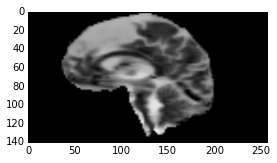

In [449]:
##################input_path = '/Shared/johnsonhj/HDNI/20150319_DWIProcessing/Results/PHD_024/1155/87312/DWIWorkflow_CACHE_87312/EstimationWorkflow_CACHE_87312/DTIProcess'
input_path = '/Shared/johnsonhj/HDNI/20150319_DWIProcessing/Results/PHD_120/0095/13195/Outputs/DTI_RIS'
#input_path = '/raid0/homes/aghayoor/Desktop/3'
RIS_fn = os.path.join(input_path,RISname+'.nrrd')
print(RIS_fn)
RIS = sitk.ReadImage(RIS_fn)
size=RIS.GetSize()
myshow(sitk.Expand(RIS[size[0]//2,:,:],[4,4,4]))
print(RIS.GetPixelIDTypeAsString())

###### First we compute the statistics of FA in its original space using the label map created from experiment 1.

In [450]:
print(whole_mask.GetPixelIDTypeAsString())

statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(RIS, whole_mask)
print(statFilter.GetNumberOfLabels())
labelID=1

print('mean:',statFilter.GetMean(labelID))
print('std:',statFilter.GetSigma(labelID))
print('max:',statFilter.GetMaximum(labelID))
print('min:',statFilter.GetMinimum(labelID))
print('median:',statFilter.GetMedian(labelID))
print('Num of voxels:',statFilter.GetCount(labelID))

voxelSize=RIS.GetSpacing()[0]*RIS.GetSpacing()[1]*RIS.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

8-bit unsigned integer
2
mean: 0.00128152987677
std: 0.000738647700707
max: 0.00403206981714
min: -3.25260651746e-19
median: 0.00104320939863
Num of voxels: 148599
effective_volume: 1188792.0


newmask = RIS<0
size=newmask.GetSize()
myshow(sitk.LabelToRGB(newmask[size[0]//2,:,::-1]))
print(newmask.GetPixelIDTypeAsString())

statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(RIS, newmask)
print(statFilter.GetNumberOfLabels())
labelID=1

print('mean:',statFilter.GetMean(labelID))
print('std:',statFilter.GetSigma(labelID))
print('max:',statFilter.GetMaximum(labelID))
print('min:',statFilter.GetMinimum(labelID))
print('median:',statFilter.GetMedian(labelID))
print('Num of voxels:',statFilter.GetCount(labelID))

voxelSize=RIS.GetSpacing()[0]*RIS.GetSpacing()[1]*RIS.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

###### SimpleIKT + 'Linear' interpolation

64-bit float
2
mean: 0.00126604876409
std: 0.000681476768884
max: 0.00413310967267
min: 0.0
median: 0.00107363972347
Num of voxels: 1188493
effective_volume: 1188493.0


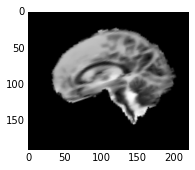

In [451]:
# Now I use run cubic BSpline on sqrt values of image, and squars the output resample image!
# mask for values -1e-6<x<1e-6
binaryThreshFilt = sitk.BinaryThresholdImageFilter()
maskNearZero = binaryThreshFilt.Execute(RIS,-1e-5,1e-5,0,1)
RIS = RIS * sitk.Cast(maskNearZero,sitk.sitkFloat64)


# resample MD to label map space
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(neuroLabels)
resFilt.SetOutputPixelType(RIS.GetPixelIDValue())
resFilt.SetInterpolator(sitk.sitkLinear)
RIS_res = resFilt.Execute(RIS)

print(RIS_res.GetPixelIDTypeAsString())

size=RIS_res.GetSize()
myshow(RIS_res[size[0]//2,:,::-1])
####################### 

whole_brain_mask = neuroLabels>0
labelID = 1

statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(RIS_res, whole_brain_mask)
print(statFilter.GetNumberOfLabels())
print('mean:',statFilter.GetMean(labelID))
print('std:',statFilter.GetSigma(labelID))
print('max:',statFilter.GetMaximum(labelID))
print('min:',statFilter.GetMinimum(labelID))
print('median:',statFilter.GetMedian(labelID))
print('Num of voxels:',statFilter.GetCount(labelID))
voxelSize=RIS_res.GetSpacing()[0]*RIS_res.GetSpacing()[1]*RIS_res.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)

###### 'sqrt voxel-wise + cubic BSpline + square voxel-wise'

2
mean: 0.137022632135
std: 0.144409771827
max: 1.51881198882
min: 1.02941330209e-16
median: 0.0919593162835
Num of voxels: 1188493
effective_volume: 1188493.0


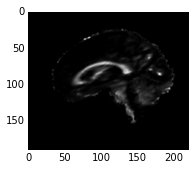

In [438]:
# Now I use run cubic BSpline on sqrt values of image, and squars the output resample image!
# mask for values -1e-6<x<1e-6
binaryThreshFilt = sitk.BinaryThresholdImageFilter()
maskNearZero = binaryThreshFilt.Execute(RIS,-1e-5,1e-5,0,1)
RIS = RIS * sitk.Cast(maskNearZero,sitk.sitkFloat64)

# 1-sqrt image
sqrtFilt = sitk.SqrtImageFilter()
RIS_sqrt = sqrtFilt.Execute(RIS)

# 2-resample image
resFilt = sitk.ResampleImageFilter()
resFilt.SetReferenceImage(neuroLabels)
resFilt.SetInterpolator(sitk.sitkBSpline)
RIS_sqrt_res = resFilt.Execute(RIS_sqrt)

# 3-square the image
squarFilt = sitk.SquareImageFilter()
RIS_res = squarFilt.Execute(RIS_sqrt_res)

size=RIS_res.GetSize()
myshow(RIS_res[size[0]//2,:,::-1])
####################### 

whole_brain_mask = neuroLabels>0
labelID = 1

statFilter = sitk.LabelStatisticsImageFilter()
statFilter.Execute(RIS_res, whole_brain_mask)
print(statFilter.GetNumberOfLabels())

print('mean:',statFilter.GetMean(labelID))
print('std:',statFilter.GetSigma(labelID))
print('max:',statFilter.GetMaximum(labelID))
print('min:',statFilter.GetMinimum(labelID))
print('median:',statFilter.GetMedian(labelID))
print('Num of voxels:',statFilter.GetCount(labelID))

voxelSize=RIS_res.GetSpacing()[0]*RIS_res.GetSpacing()[1]*RIS_res.GetSpacing()[2]
effective_volume=statFilter.GetCount(labelID) * voxelSize
print('effective_volume:',effective_volume)